# 🌸 Variational Quantum Classifier (VQC): Iris Dataset Analysis

This notebook implements a **Variational Quantum Classifier (VQC)** for binary classification on the classic **Iris dataset**.
We classify between two Iris species (setosa vs versicolor) using a 4-qubit quantum circuit with data re-uploading.

### 🎯 Learning Objectives
By completing this notebook, you will:
- Understand how to build a **VQC with data re-uploading** architecture
- Learn the **SPSA (Simultaneous Perturbation Stochastic Approximation)** optimization technique
- Explore **quantum saliency methods** for feature importance analysis
- Evaluate model **stability** across different random seeds and shot counts

### 🏗️ VQC Architecture
Our quantum circuit uses:
- **Data Encoding:** RY rotations encode 4 Iris features into qubit rotations
- **Entanglement:** CNOT ring topology connects all qubits
- **Variational Layers:** Trainable RZ and RY rotations for expressivity
- **Measurement:** Z-expectation on qubit 0 mapped to class probability

### ⚛️ Technologies Used
- **Qiskit:** QuantumCircuit, ParameterVector, SparsePauliOp
- **Qiskit Primitives:** Estimator (statevector), AerEstimator (shot-based)
- **scikit-learn:** StandardScaler, train_test_split, confusion_matrix
- **NumPy & Matplotlib:** Numerical computation and visualization

### 📊 Interpretability Toolkit
We implement multiple saliency methods:
- **Gradient-based saliency** via parameter-shift rule
- **SmoothGrad** for noise-robust attribution
- **Integrated Gradients** for path-based attribution
- **Occlusion** for perturbation-based importance
- **Noise Sensitivity** for robustness analysis
- **Deletion Metric** for faithfulness evaluation
- **Entropy & Sparseness** for saliency quality assessment

---

*Part of the QAMP Project: "QNNs — Saliency & Sensitivity Kit"*

## 🛠️ Experimental Setup

### 📦 Install Required Packages

Run this cell to install all necessary dependencies before proceeding with the notebook.

In [1]:
# Install required packages (run once, then restart kernel if needed)
!pip install qiskit==1.3.1 qiskit-aer==0.15.1 numpy==2.2.1 matplotlib==3.10.0 pandas==2.2.3 scikit-learn==1.7.2 scipy==1.14.1

### 🧩 Import Libraries & Configuration

We import the essential libraries for:
- **Data handling:** NumPy, scikit-learn (Iris dataset, preprocessing, metrics)
- **Quantum computing:** Qiskit (circuits, parameters, observables, estimators)
- **Visualization:** Matplotlib for plotting results

The `Config` dataclass centralizes all hyperparameters for easy experimentation:
- `n_layers`: Number of variational layers in the quantum circuit
- `feature_scale`: Scaling factor (π) for angle encoding
- `lr`, `spsa_eps`: SPSA optimizer learning rate and perturbation size
- `iters`, `target_acc`: Training iterations and early stopping threshold

In [2]:
import os, math, json, time, random
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator   # v1 (deprecated warning is ok here)
from qiskit_aer.primitives import Estimator as AerEstimator

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

@dataclass
class Config:
    # model
    n_layers: int = 2
    feature_scale: float = np.pi

    shots_train: int | None = None
    lr: float = 0.06
    spsa_eps: float = 0.10
    iters: int = 350
    target_acc: float = 0.95
    batch_size: int = 24

    shots_plot: int | None = 256
    grid_points: int = 80
    grid_chunk: int = 512

    # data
    train_size: float = 0.7
    val_size: float = 0.15

CFG = Config()

### 📊 Data Preparation

We load the **Iris dataset** and prepare it for quantum classification:

1. **Binary Classification:** We use only classes 0 (setosa) and 1 (versicolor), dropping class 2 (virginica)
2. **Standardization:** Features are z-score normalized using `StandardScaler`
3. **Angle Encoding:** Scaled features are mapped to angles in the range [-π, π] for quantum gate rotations
4. **Data Splits:** 70% training, 15% validation, 15% test (stratified to preserve class balance)

The 4 Iris features are:
- **Sepal length** (cm)
- **Sepal width** (cm)
- **Petal length** (cm)
- **Petal width** (cm)

In [3]:
iris = load_iris()
X_all = iris.data.astype(np.float64)
y_all = iris.target

# Binary task: classes 0 vs 1 (drop class 2)
mask = (y_all != 2)
X = X_all[mask]
y = y_all[mask]  # 0/1

# standardize then scale to angles
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)
Xenc = CFG.feature_scale * (Xz / np.max(np.abs(Xz), axis=0, keepdims=True))

# splits
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    Xenc, y, test_size=1-CFG.train_size, random_state=SEED, stratify=y
)
rel_val = CFG.val_size / (1 - CFG.train_size)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=1-rel_val, random_state=SEED, stratify=y_tmp
)

X_tr.shape, X_val.shape, X_te.shape

((69, 4), (15, 4), (16, 4))

## 🔮 Quantum Circuit Construction

### ⚛️ Building the VQC Architecture

The Variational Quantum Classifier uses a **data re-uploading** strategy where:

1. **Feature Encoding (RY gates):** Each layer re-encodes the 4 input features as RY rotations
2. **Entanglement (CNOT ring):** A ring of CNOT gates creates quantum correlations between qubits
3. **Variational Rotations (RZ, RY):** Trainable parameters allow the circuit to learn decision boundaries

This layered structure with repeated encoding is proven to enhance the expressivity of quantum classifiers.

**Circuit Structure per Layer:**
```
|0⟩ ─ RY(x₀) ─ ●─────────────○─ RZ(θ₀) ─ RY(θ₁) ─
|0⟩ ─ RY(x₁) ─ ○─ ●───────── ─ RZ(θ₂) ─ RY(θ₃) ─
|0⟩ ─ RY(x₂) ─────○─ ●─────  ─ RZ(θ₄) ─ RY(θ₅) ─
|0⟩ ─ RY(x₃) ───────── ○─ ● ─ RZ(θ₆) ─ RY(θ₇) ─
```

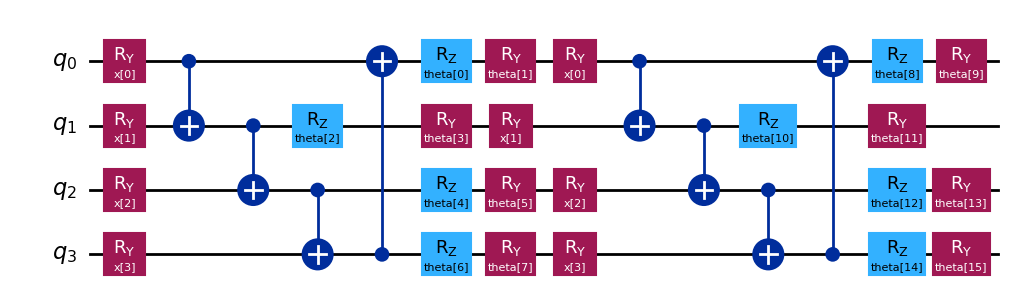

In [4]:
def build_vqc(n_features=4, n_layers=3):
    
    qc = QuantumCircuit(n_features, name="VQC")
    x = ParameterVector("x", n_features)
    theta = ParameterVector("theta", n_layers * n_features * 2)

    t = 0
    for _ in range(n_layers):
        # encode features each layer
        for i in range(n_features):
            qc.ry(x[i], i)
        # CX ring
        for i in range(n_features - 1):
            qc.cx(i, i+1)
        qc.cx(n_features - 1, 0)
        # trainable rotations
        for i in range(n_features):
            qc.rz(theta[t], i); t += 1
            qc.ry(theta[t], i); t += 1
    return qc, x, theta

qc, x_par, th_par = build_vqc(n_features=X_tr.shape[1], n_layers=CFG.n_layers)
qc.draw('mpl')

### 🏷️ Parameter Metadata

To interpret which trainable parameters are most important, we build metadata tracking:
- **Layer index (L):** Which layer the parameter belongs to
- **Qubit index (q):** Which qubit the gate acts on
- **Gate type (op):** Whether it's an RZ or RY rotation

This metadata is crucial for the **parameter sensitivity analysis** later in the notebook.

In [5]:
# 3b. === Build metadata for theta ordering ===
def build_theta_meta(n_features: int, n_layers: int):
    """
    Returns a list of (layer, qubit, op) in the exact order that 'theta'
    is appended inside build_vqc:
      for each layer:
        for each qubit: RZ(theta); RY(theta)
    """
    meta = []
    for L in range(n_layers):
        for q in range(n_features):
            meta.append((L, q, "rz"))
            meta.append((L, q, "ry"))
    return meta

THETA_META = build_theta_meta(n_features=X_tr.shape[1], n_layers=CFG.n_layers)
assert len(THETA_META) == len(th_par), f"Meta len {len(THETA_META)} != theta size {len(th_par)}"
print(f"[THETA_META] {len(THETA_META)} params; head:", THETA_META[:6])

[THETA_META] 16 params; head: [(0, 0, 'rz'), (0, 0, 'ry'), (0, 1, 'rz'), (0, 1, 'ry'), (0, 2, 'rz'), (0, 2, 'ry')]


### 📐 Observable & Estimator Setup

**Observable Definition:**
We measure the Z-expectation value on qubit 0: $\langle Z_0 \rangle \in [-1, +1]$

**Probability Mapping:**
The expectation is mapped to a probability via: $P(\text{class}=1) = \frac{1 + \langle Z \rangle}{2}$

**Estimator Options:**
- **Exact (shots=None):** Statevector simulation for ideal gradients
- **Shot-based:** Realistic sampling noise for hardware-like conditions

The `predict_score` function batches circuit evaluations for efficiency.

In [6]:
# measure Z on qubit 0 (rightmost char is qubit 0)
nq = X_tr.shape[1]
obs_label = "I"*(nq-1) + "Z"
obs = SparsePauliOp.from_list([(obs_label, 1.0)])

def build_estimator(shots):
    if shots is None:
        return Estimator()
    else:
        return AerEstimator(run_options={"shots": shots, "seed": SEED})

# build both estimators
est_train = build_estimator(CFG.shots_train)
est_plot  = build_estimator(CFG.shots_plot)

def score_to_proba(z):  # map expectation [-1,1] -> prob[0,1]
    return (1.0 + z) * 0.5

def predict_score(theta_vals, X_batch, estimator=None):
    e = estimator or est_train
    circuits, observables, parameter_values = [], [], []
    for xb in X_batch:
        vals = list(map(float, xb)) + list(map(float, theta_vals))
        parameter_values.append(vals)
        circuits.append(qc)
        observables.append(obs)
    job = e.run(circuits, observables, parameter_values=parameter_values)
    return np.array(job.result().values, dtype=float)  # shape [B, 1]

/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:14: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_plot  = build_estimator(CFG.shots_plot)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_plot  = build_estima

## 🚀 Training with SPSA Optimizer

### ⚡ SPSA: Simultaneous Perturbation Stochastic Approximation

SPSA is a **gradient-free optimization** algorithm ideal for quantum circuits because:
- It requires only **2 circuit evaluations** per iteration (vs. 2×parameters for parameter-shift)
- It handles **noisy objective functions** well (important for shot-based training)
- It scales efficiently with the number of parameters

**Algorithm:**
1. Sample random perturbation direction $\Delta \in \{-1, +1\}^d$
2. Evaluate loss at $\theta + c_k\Delta$ and $\theta - c_k\Delta$
3. Estimate gradient: $\hat{g} = \frac{L^+ - L^-}{2c_k} \Delta$
4. Update: $\theta_{k+1} = \theta_k - a_k \hat{g}$

**Learning Rate Schedule:**
- $a_k = a_0 / (1 + 0.01k)$ — mild decay for stable convergence
- $c_k = c_0 / (1 + 0.002k)$ — perturbation size annealing

In [7]:
def bce_loss(p, y):
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    return - (y * np.log(p) + (1 - y) * np.log(1 - p)).mean()

def batch_acc(theta, Xb, yb, estimator=None):
    z = predict_score(theta, Xb, estimator=estimator).ravel()
    p = score_to_proba(z)
    yhat = (p >= 0.5).astype(int)
    return accuracy_score(yb, yhat)

def spsa_step(theta, Xb, yb, k, a0=CFG.lr, c0=CFG.spsa_eps, estimator=None):
    d = theta.size
    delta = np.random.choice([-1.0, 1.0], size=d)
    ak = a0 / (1.0 + 0.01 * k)    # mild decay
    ck = c0 / (1.0 + 0.002 * k)

    thetap = theta + ck * delta
    thetam = theta - ck * delta

    z_p = predict_score(thetap, Xb, estimator=estimator).ravel()
    z_m = predict_score(thetam, Xb, estimator=estimator).ravel()
    Lp = bce_loss(score_to_proba(z_p), yb)
    Lm = bce_loss(score_to_proba(z_m), yb)
    ghat = (Lp - Lm) / (2.0 * ck) * delta
    new_theta = theta - ak * ghat
    return new_theta, Lp, Lm

def train_vqc_spsa(X_tr, y_tr, X_val, y_val, iters=CFG.iters, batch_size=CFG.batch_size):
    theta = np.random.uniform(-0.1, 0.1, size=len(th_par))
    history = {"train_loss": [], "val_acc": []}
    for k in range(1, iters+1):
        idx = np.random.choice(len(X_tr), size=min(batch_size, len(X_tr)), replace=False)
        Xb, yb = X_tr[idx], y_tr[idx]
        theta, Lp, Lm = spsa_step(theta, Xb, yb, k, estimator=est_train)

        # quick metrics
        z = predict_score(theta, Xb, estimator=est_train).ravel()
        train_loss = bce_loss(score_to_proba(z), yb)
        val_acc = batch_acc(theta, X_val, y_val, estimator=est_train)

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        if k % 10 == 0:
            print(f"Iter {k:03d} | train_loss={train_loss:.4f} | val_acc={val_acc*100:.1f}%")
        if val_acc >= CFG.target_acc:
            print(f"Early stop at iter {k}: val_acc={val_acc*100:.1f}%")
            break
    return theta, history

### 🎯 Run Training

Execute the training loop with early stopping when validation accuracy reaches the target threshold.

In [8]:
theta_star, hist = train_vqc_spsa(X_tr, y_tr, X_val, y_val)

Iter 010 | train_loss=0.3978 | val_acc=80.0%
Iter 020 | train_loss=0.2947 | val_acc=93.3%
Iter 030 | train_loss=0.3209 | val_acc=93.3%
Early stop at iter 31: val_acc=100.0%


### 📈 Training Curves & Test Evaluation

Visualize the training dynamics:
- **Loss curve:** Shows BCE loss decreasing over iterations
- **Accuracy curve:** Shows validation accuracy improving
- **Test accuracy:** Final evaluation on held-out test set

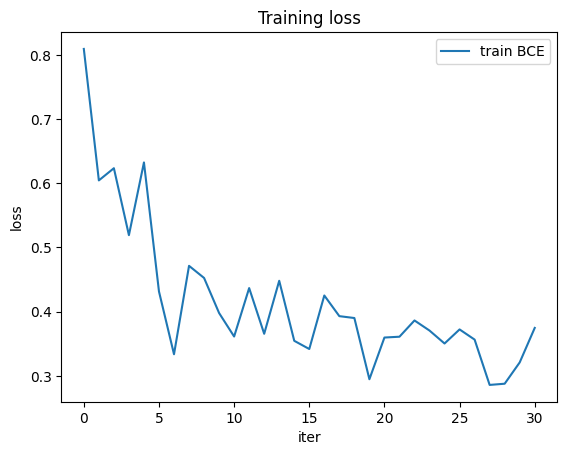

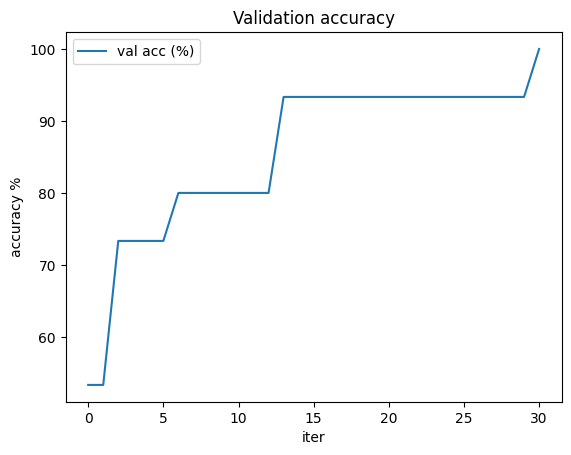

[VQC] Test accuracy: 93.75%


In [9]:
plt.figure(); plt.plot(hist["train_loss"], label="train BCE")
plt.legend(); plt.xlabel("iter"); plt.ylabel("loss"); plt.title("Training loss"); plt.show()

plt.figure(); plt.plot([a*100 for a in hist["val_acc"]], label="val acc (%)")
plt.legend(); plt.xlabel("iter"); plt.ylabel("accuracy %"); plt.title("Validation accuracy"); plt.show()

test_acc = batch_acc(theta_star, X_te, y_te, estimator=est_train)
print(f"[VQC] Test accuracy: {test_acc*100:.2f}%")

## 🔍 Feature Saliency Analysis

### 🎨 Gradient-Based Input Saliency

We use the **parameter-shift rule** to compute exact gradients of the quantum circuit output with respect to input features:

$$\frac{\partial \langle Z \rangle}{\partial x_j} = \frac{1}{2}\left[\langle Z \rangle_{x_j + \pi/2} - \langle Z \rangle_{x_j - \pi/2}\right]$$

**Saliency = |∂z/∂x|** indicates how much each feature influences the model's prediction.

Higher saliency → more important feature for classification.

Per-feature saliency (|∂z/∂x|): [0.00130227 0.05987506 0.04552388 0.25136692]
Global feature saliency: [0.00087561 0.07995984 0.04982139 0.47066982]


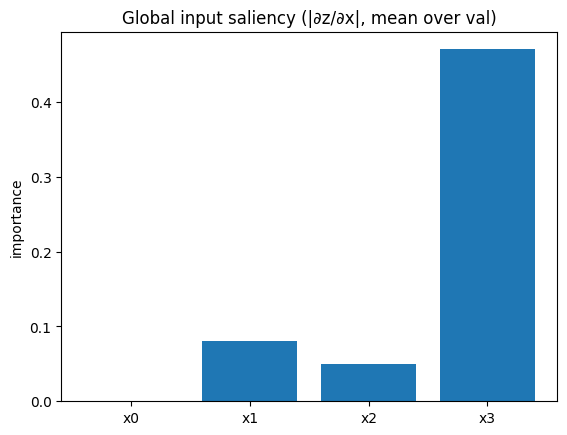

In [10]:
PS_SHIFT = np.pi/2

def vqc_expectation(theta_vals, x_vec, estimator=None):
    return float(predict_score(theta_vals, x_vec[None, :], estimator=estimator).ravel()[0])

def grad_input_param_shift(theta_vals, x_vec, shift=PS_SHIFT, estimator=None):
    g = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        x_p = x_vec.copy(); x_p[j] += shift
        x_m = x_vec.copy(); x_m[j] -= shift
        z_p = vqc_expectation(theta_vals, x_p, estimator=est_train)
        z_m = vqc_expectation(theta_vals, x_m, estimator=est_train)
        g[j] = 0.5 * (z_p - z_m)
    return g  # ∂z/∂x

# one sample + global mean
idx = 0
x0, y0 = X_val[idx], y_val[idx]
g_x = np.abs(grad_input_param_shift(theta_star, x0))
print("Per-feature saliency (|∂z/∂x|):", g_x)

G = np.stack([np.abs(grad_input_param_shift(theta_star, X_val[i])) for i in range(len(X_val))])
global_saliency = G.mean(axis=0)
print("Global feature saliency:", global_saliency)

plt.figure(); plt.bar(range(len(global_saliency)), global_saliency)
plt.xticks(range(X_val.shape[1]), [f"x{j}" for j in range(X_val.shape[1])])
plt.title("Global input saliency (|∂z/∂x|, mean over val)"); plt.ylabel("importance"); plt.show()

### 🌫️ SmoothGrad Saliency

**SmoothGrad** reduces noise in gradient-based saliency by averaging over multiple noisy copies of the input:

$$\text{SmoothGrad}(x) = \frac{1}{K} \sum_{k=1}^{K} \left|\nabla_x f(x + \epsilon_k)\right|, \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2)$$

This produces **smoother, more interpretable** saliency maps by filtering out gradient artifacts.

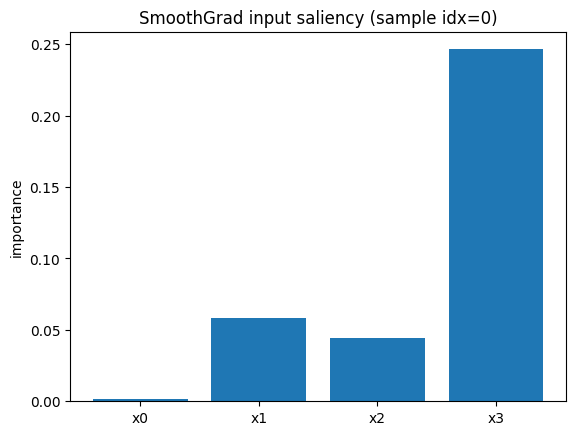

In [11]:
def smoothgrad_saliency(theta_vals, x_vec, K=30, sigma=0.1):
    grads = []
    for _ in range(K):
        x_noisy = x_vec + np.random.normal(0.0, sigma, size=x_vec.shape)
        grads.append(np.abs(grad_input_param_shift(theta_vals, x_noisy)))
    return np.mean(np.stack(grads), axis=0)

sg = smoothgrad_saliency(theta_star, x0, K=30, sigma=0.1)
plt.figure()
plt.bar(range(len(sg)), sg)
plt.xticks(range(X_val.shape[1]), [f"x{j}" for j in range(X_val.shape[1])])
plt.title("SmoothGrad input saliency (sample idx=0)"); plt.ylabel("importance")
plt.show()

### 🗺️ Decision Surface Visualization

We visualize the VQC's decision boundary in the 2D subspace of the **top-2 most salient features**.

- **Contour plot:** Shows probability $P(\text{class}=1)$ across the feature space
- **Scatter points:** Training, validation, and test samples colored by true class
- **Confusion matrix:** Summarizes classification performance on test set

This visualization helps understand how the quantum classifier partitions the feature space.

Decision surface with features x1 & x3; shots_plot=256


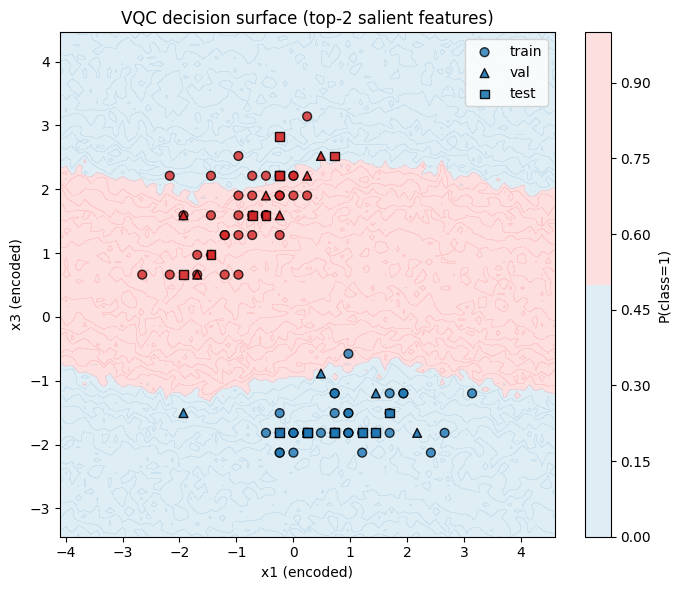

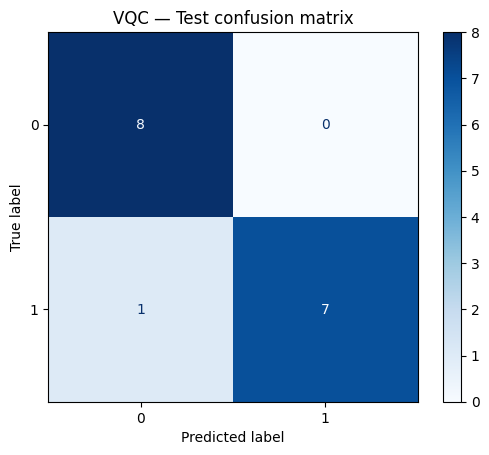

Test accuracy: 93.75%


In [12]:
def decision_grid(theta_vals, Xref, i1, i2, n_points=None, estimator=None, margin=0.25):
    e = estimator or est_plot
    n_points = n_points or CFG.grid_points

    f1_min, f1_max = Xref[:, i1].min(), Xref[:, i1].max()
    f2_min, f2_max = Xref[:, i2].min(), Xref[:, i2].max()
    dx1, dx2 = f1_max - f1_min, f2_max - f2_min
    f1_min -= margin * dx1; f1_max += margin * dx1
    f2_min -= margin * dx2; f2_max += margin * dx2

    xx, yy = np.meshgrid(np.linspace(f1_min, f1_max, n_points),
                         np.linspace(f2_min, f2_max, n_points))

    grid_pts = np.zeros((n_points*n_points, Xref.shape[1]), dtype=float)
    grid_pts[:, i1] = xx.ravel()
    grid_pts[:, i2] = yy.ravel()

    probs = np.empty((grid_pts.shape[0],), dtype=float)
    for s in range(0, grid_pts.shape[0], CFG.grid_chunk):
        batch = grid_pts[s:s+CFG.grid_chunk]
        z = predict_score(theta_vals, batch, estimator=e).ravel()
        probs[s:s+CFG.grid_chunk] = score_to_proba(z)
    return xx, yy, probs.reshape(xx.shape)

# choose top-2 salient features by global_saliency
top2 = np.argsort(global_saliency)[-2:]
i1, i2 = sorted(top2.tolist())
print(f"Decision surface with features x{i1} & x{i2}; shots_plot={CFG.shots_plot}")

xx, yy, p = decision_grid(theta_star, Xenc, i1, i2, estimator=est_plot)

def scatter_split(ax, Xpart, ypart, label, marker, alpha=0.9):
    ax.scatter(Xpart[:, i1], Xpart[:, i2], c=ypart,
               cmap=ListedColormap(["#1f77b4","#d62728"]),
               edgecolors="k", s=40, marker=marker, label=label, alpha=alpha)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, p, levels=np.linspace(0,1,21), alpha=0.35,
             cmap=ListedColormap(["#A6CEE3","#FCA5A5"]))
plt.colorbar(label="P(class=1)")
scatter_split(plt.gca(), X_tr, y_tr, "train", "o", 0.8)
scatter_split(plt.gca(), X_val, y_val, "val", "^", 0.9)
scatter_split(plt.gca(), X_te,  y_te,  "test", "s", 0.9)
plt.xlabel(f"x{i1} (encoded)"); plt.ylabel(f"x{i2} (encoded)")
plt.title("VQC decision surface (top-2 salient features)")
plt.legend(); plt.tight_layout(); plt.show()

# confusion matrix on test split (using training estimator)
z_te = predict_score(theta_star, X_te, estimator=est_train).ravel()
p_te = score_to_proba(z_te)
yhat_te = (p_te >= 0.5).astype(int)
cm = confusion_matrix(y_te, yhat_te, labels=[0,1])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("VQC — Test confusion matrix"); plt.show()

print(f"Test accuracy: {(yhat_te==y_te).mean()*100:.2f}%")

## 📊 Stability Analysis

### 🎲 Seed & Shot Noise Robustness

Quantum machine learning results can vary due to:
1. **Random initialization:** Different starting parameters
2. **Shot noise:** Statistical fluctuations from finite measurements

We evaluate **stability** by training multiple models with different seeds and comparing:
- **Test accuracy:** Mean ± std across runs
- **Saliency consistency:** Spearman correlation between feature rankings

Stable saliency rankings indicate **reliable interpretations** of feature importance.

In [13]:
import copy
from numpy.random import RandomState

def spearman_corr(a, b):
    ra = np.argsort(np.argsort(a))
    rb = np.argsort(np.argsort(b))
    return np.corrcoef(ra, rb)[0,1]

def run_once_with_seed(seed, shots_train):
    global est_train

    est_train = build_estimator(shots_train)

    # Re-seed numpy/random for reproducibility
    np.random.seed(seed); random.seed(seed)

    # Fresh init and train
    theta, hist = train_vqc_spsa(X_tr, y_tr, X_val, y_val)

    # Metrics
    acc_te = batch_acc(theta, X_te, y_te, estimator=est_train)

    # Global saliency on val
    G = np.stack([np.abs(grad_input_param_shift(theta, X_val[i])) for i in range(len(X_val))])
    glob = G.mean(axis=0)
    return acc_te, glob, theta

def stability_suite(shots_train, seeds=(0,1,2,3,4)):
    accs, globs = [], []
    for s in seeds:
        acc, glob, _ = run_once_with_seed(s, shots_train)
        accs.append(acc); globs.append(glob)
    accs = np.array(accs); globs = np.stack(globs)
    # Spearman vs first seed
    rhos = [spearman_corr(globs[0], globs[i]) for i in range(1, len(seeds))]
    return accs, globs, rhos

print("== Exact (shots=None) ==")
accs_exact, globs_exact, rhos_exact = stability_suite(shots_train=None)
print(f"Test acc mean±std: {accs_exact.mean()*100:.1f} ± {accs_exact.std()*100:.1f}%")
print(f"Saliency stability (Spearman vs seed0): {np.round(rhos_exact,3)}")

print("\n== Shot-based (shots=1000) ==")
accs_shot, globs_shot, rhos_shot = stability_suite(shots_train=1000)
print(f"Test acc mean±std: {accs_shot.mean()*100:.1f} ± {accs_shot.std()*100:.1f}%")
print(f"Saliency stability (Spearman vs seed0): {np.round(rhos_shot,3)}")

== Exact (shots=None) ==


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.3599 | val_acc=73.3%
Iter 020 | train_loss=0.3812 | val_acc=86.7%
Iter 030 | train_loss=0.3400 | val_acc=93.3%
Iter 040 | train_loss=0.3452 | val_acc=93.3%
Early stop at iter 41: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.5829 | val_acc=73.3%
Iter 020 | train_loss=0.3617 | val_acc=80.0%
Iter 030 | train_loss=0.3641 | val_acc=86.7%
Iter 040 | train_loss=0.3601 | val_acc=93.3%
Early stop at iter 49: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.4200 | val_acc=73.3%
Iter 020 | train_loss=0.3483 | val_acc=86.7%
Iter 030 | train_loss=0.3651 | val_acc=86.7%
Early stop at iter 36: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.3947 | val_acc=80.0%
Iter 020 | train_loss=0.3906 | val_acc=86.7%
Iter 030 | train_loss=0.3396 | val_acc=93.3%
Iter 040 | train_loss=0.3172 | val_acc=93.3%
Early stop at iter 46: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/4285711255.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.4930 | val_acc=73.3%
Iter 020 | train_loss=0.3982 | val_acc=93.3%
Early stop at iter 23: val_acc=100.0%
Test acc mean±std: 90.0 ± 3.1%
Saliency stability (Spearman vs seed0): [1.  1.  1.  0.8]

== Shot-based (shots=1000) ==


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_train = build_estimator(shots_train)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_train = build_estimator(shots_train)


Iter 010 | train_loss=0.3584 | val_acc=73.3%
Iter 020 | train_loss=0.3806 | val_acc=86.7%
Iter 030 | train_loss=0.3439 | val_acc=93.3%
Early stop at iter 38: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_train = build_estimator(shots_train)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_train = build_estimator(shots_train)


Iter 010 | train_loss=0.5881 | val_acc=73.3%
Iter 020 | train_loss=0.3667 | val_acc=80.0%
Iter 030 | train_loss=0.3646 | val_acc=86.7%
Iter 040 | train_loss=0.3557 | val_acc=93.3%
Early stop at iter 44: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_train = build_estimator(shots_train)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_train = build_estimator(shots_train)


Iter 010 | train_loss=0.4251 | val_acc=73.3%
Iter 020 | train_loss=0.3594 | val_acc=86.7%
Iter 030 | train_loss=0.3656 | val_acc=86.7%
Early stop at iter 34: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_train = build_estimator(shots_train)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_train = build_estimator(shots_train)


Iter 010 | train_loss=0.3898 | val_acc=80.0%
Iter 020 | train_loss=0.3892 | val_acc=86.7%
Iter 030 | train_loss=0.3443 | val_acc=86.7%
Early stop at iter 39: val_acc=100.0%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_train = build_estimator(shots_train)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_34257/1349653862.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_train = build_estimator(shots_train)


Iter 010 | train_loss=0.4930 | val_acc=73.3%
Iter 020 | train_loss=0.4046 | val_acc=93.3%
Early stop at iter 23: val_acc=100.0%
Test acc mean±std: 90.0 ± 3.1%
Saliency stability (Spearman vs seed0): [1.  1.  1.  0.8]


### 📊 Accuracy Comparison: Exact vs Shot-Based

Compare test accuracy between ideal (statevector) and realistic (shot-based) training.

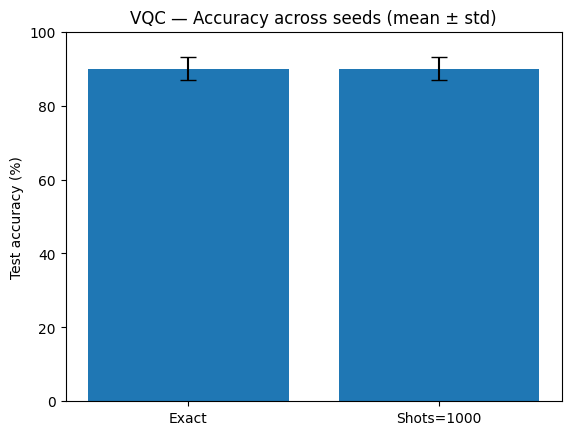

In [14]:
labels = ["Exact", "Shots=1000"]
means  = [accs_exact.mean()*100, accs_shot.mean()*100]
stds   = [accs_exact.std()*100,  accs_shot.std()*100]

plt.figure()
plt.bar(range(2), means, yerr=stds, capsize=6)
plt.xticks(range(2), labels)
plt.ylim(0, 100)
plt.ylabel("Test accuracy (%)")
plt.title("VQC — Accuracy across seeds (mean ± std)")
plt.show()

### 🌸 Feature Importance Across Seeds

Compare global saliency between exact and shot-based training to assess interpretation stability.

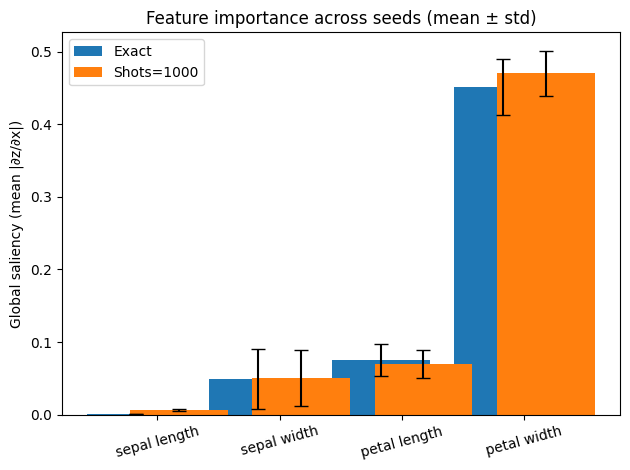

In [15]:
feat_names = np.array(["sepal length","sepal width","petal length","petal width"])
m_exact, s_exact = globs_exact.mean(axis=0), globs_exact.std(axis=0)
m_shot,  s_shot  = globs_shot.mean(axis=0),  globs_shot.std(axis=0)

x = np.arange(len(feat_names))
w = 0.35

plt.figure()
plt.bar(x - w/2, m_exact, yerr=s_exact, capsize=5, label="Exact")
plt.bar(x + w/2, m_shot,  yerr=s_shot,  capsize=5, label="Shots=1000")
plt.xticks(x, feat_names, rotation=15)
plt.ylabel("Global saliency (mean |∂z/∂x|)")
plt.title("Feature importance across seeds (mean ± std)")
plt.legend()
plt.tight_layout()
plt.show()

### 🔥 Saliency Rank Stability Heatmaps

Pairwise Spearman correlation between saliency rankings from different seeds.
Values close to 1 indicate stable, reproducible feature importance rankings.

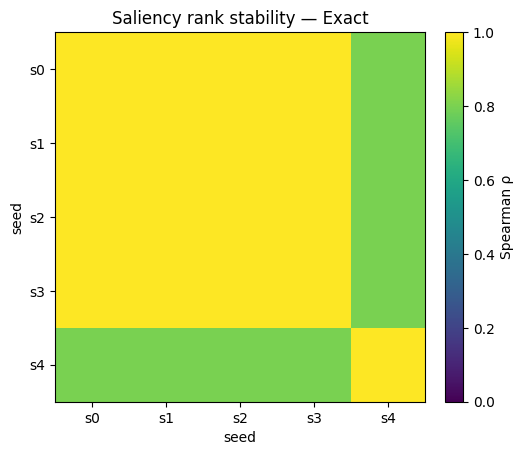

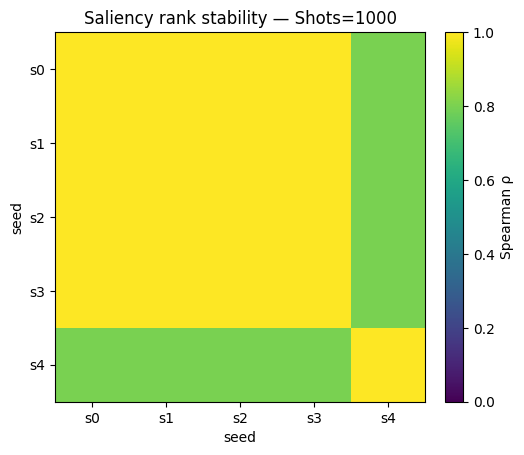

In [16]:
def pairwise_spearman(globs):
    n = globs.shape[0]
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            ra = np.argsort(np.argsort(globs[i]))
            rb = np.argsort(np.argsort(globs[j]))
            M[i,j] = np.corrcoef(ra, rb)[0,1]
    return M

M_exact = pairwise_spearman(globs_exact)
M_shot  = pairwise_spearman(globs_shot)

def show_heatmap(M, title):
    plt.figure()
    im = plt.imshow(M, vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman ρ")
    plt.xticks(range(M.shape[0]), [f"s{i}" for i in range(M.shape[0])])
    plt.yticks(range(M.shape[0]), [f"s{i}" for i in range(M.shape[0])])
    plt.title(title)
    plt.xlabel("seed"); plt.ylabel("seed")
    plt.show()

show_heatmap(M_exact, "Saliency rank stability — Exact")
show_heatmap(M_shot,  "Saliency rank stability — Shots=1000")

## 🧠 Advanced Interpretability Metrics

### ⚙️ Metric Configuration

Configure constants for advanced attribution methods:
- **Integrated Gradients:** Number of interpolation steps and baseline choice
- **Noise Sensitivity:** Perturbation magnitude and number of samples

In [ ]:
from dataclasses import replace

CFG = replace(
    CFG,
    # feature-level metrics
    )
# Constants for metrics
IG_STEPS = 25         # number of Riemann steps for Integrated Gradients
IG_BASELINE = "mean"  # 'mean' or 'zero' in encoded space
NOISE_SIGMA = 0.10    # std for noise sensitivity (in encoded units)
NOISE_K = 50          # number of MC samples for noise sensitivity

### 🎯 Baseline Definition

The **baseline** is a reference point for attribution methods like Integrated Gradients.
Common choices:
- **Mean baseline:** Average feature values (captures typical input)
- **Zero baseline:** All features set to zero (neutral reference)

In [18]:
def feature_baseline(Xref, kind="mean"):
    """Return a baseline vector in encoded space."""
    if kind == "mean":
        return Xref.mean(axis=0)
    elif kind == "zero":
        return np.zeros(Xref.shape[1], dtype=float)
    else:
        raise ValueError("kind must be 'mean' or 'zero'")

BASELINE_VEC = feature_baseline(Xenc, kind=IG_BASELINE)

### 🔬 Attribution Methods Implementation

We implement four complementary attribution methods:

1. **Integrated Gradients (IG):** Path integral of gradients from baseline to input
   $$IG_j(x) = (x_j - x'_j) \times \frac{1}{m}\sum_{k=1}^{m} \frac{\partial f(x' + \frac{k}{m}(x-x'))}{\partial x_j}$$

2. **Gradient × Input:** Simple product of gradient and input value

3. **Occlusion:** Measures output change when each feature is replaced with baseline

4. **Noise Sensitivity:** Expected output change under feature-wise noise perturbation

In [19]:
def grad_input_param_shift_sample(theta_vals, x_vec, shift=PS_SHIFT):
    """∂z/∂x for a single sample via parameter-shift on data-encoding RY."""
    g = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        x_p = x_vec.copy(); x_p[j] += shift
        x_m = x_vec.copy(); x_m[j] -= shift
        z_p = vqc_expectation(theta_vals, x_p, estimator=est_train)
        z_m = vqc_expectation(theta_vals, x_m, estimator=est_train)
        g[j] = 0.5 * (z_p - z_m)
    return g

def integrated_gradients(theta_vals, x_vec, x_base=None, m_steps=IG_STEPS):
    """
    Integrated Gradients along straight path from baseline to x:
      IG_j ≈ (x_j - x'_j) * (1/m) * Σ_k ∂z(x'_j + α_k(x_j-x'_j))/∂x_j
    """
    if x_base is None:
        x_base = BASELINE_VEC
    alphas = np.linspace(0.0, 1.0, m_steps, endpoint=True)
    grads_sum = np.zeros_like(x_vec, dtype=float)
    diff = x_vec - x_base
    for a in alphas:
        x_t = x_base + a * diff
        grads_sum += grad_input_param_shift_sample(theta_vals, x_t)
    IG = diff * (grads_sum / len(alphas))
    return IG

def gradient_times_input(theta_vals, x_vec):
    """GI = x * ∂z/∂x at the input."""
    g = grad_input_param_shift_sample(theta_vals, x_vec)
    return x_vec * g

def occlusion_importance(theta_vals, Xref, baseline_vec=None, use_loss=True):
    """
    Leave-one-out: set feature j to baseline and measure Δ (loss or prob).
    Returns vector of positive importances.
    """
    if baseline_vec is None:
        baseline_vec = BASELINE_VEC
    # base metrics
    z_base = predict_score(theta_vals, Xref, estimator=est_train).ravel()
    p_base = score_to_proba(z_base)
    if use_loss:
        base_metric = bce_loss(p_base, y_val)
    # per-feature occlusion
    importances = []
    for j in range(Xref.shape[1]):
        X_occ = Xref.copy()
        X_occ[:, j] = baseline_vec[j]
        z_occ = predict_score(theta_vals, X_occ, estimator=est_train).ravel()
        p_occ = score_to_proba(z_occ)
        if use_loss:
            metric = bce_loss(p_occ, y_val)
            imp = max(0.0, metric - base_metric)        # Δloss (positive = worse)
        else:
            imp = np.mean(np.abs(p_occ - p_base))        # Δprob
        importances.append(float(imp))
    return np.array(importances, dtype=float)

def noise_sensitivity_per_feature(theta_vals, x_vec, sigma=NOISE_SIGMA, K=NOISE_K):
    """
    Expected |Δz| when only feature j is perturbed by N(0, sigma^2).
    Returns vector of sensitivities.
    """
    base_z = vqc_expectation(theta_vals, x_vec, estimator=est_train)
    sens = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        diffs = []
        for _ in range(K):
            xn = x_vec.copy()
            xn[j] += np.random.normal(0.0, sigma)
            z_n = vqc_expectation(theta_vals, xn, estimator=est_train)
            diffs.append(abs(z_n - base_z))
        sens[j] = np.mean(diffs)
    return sens

### 📊 Multi-Metric Feature Importance Comparison

Aggregate all attribution methods over the validation set and compare normalized importance scores.
Consistent rankings across methods indicate robust feature importance.

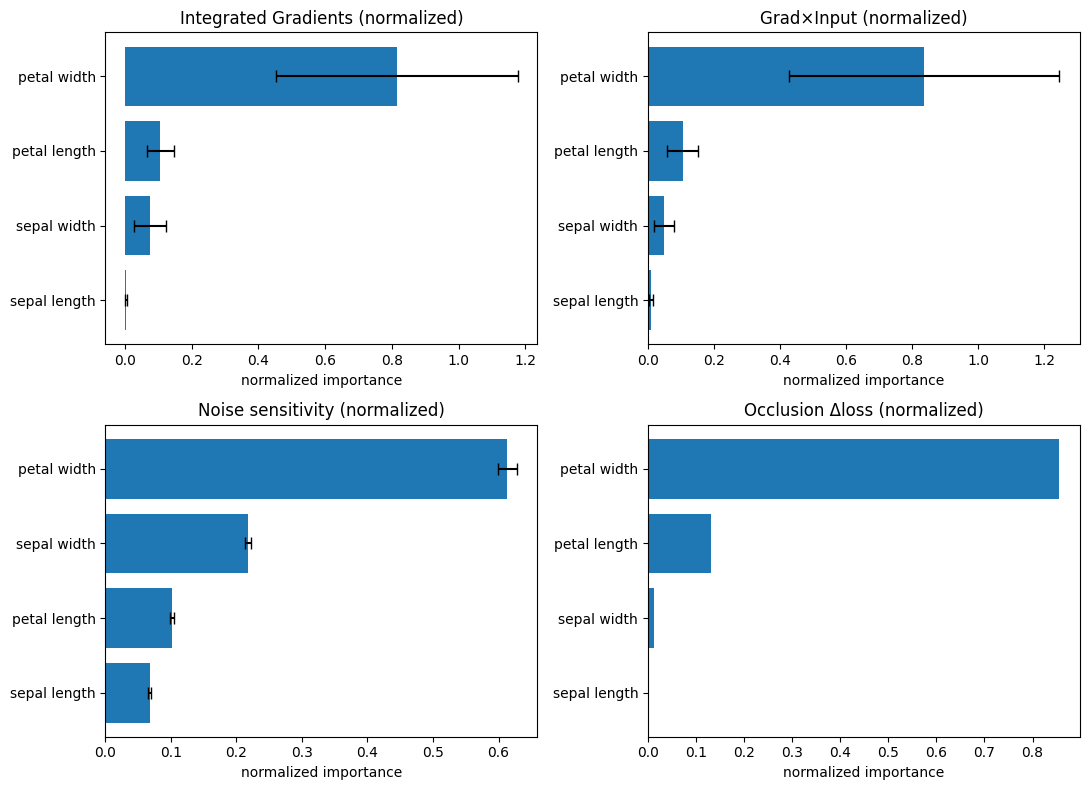

In [20]:
# -- Aggregate metrics over validation (reuse your earlier metric fns) --
idx = 0
x0, y0 = X_val[idx], y_val[idx]

def agg_metric_over_val(metric_fn):
    M = []
    for i in range(len(X_val)):
        M.append(np.abs(metric_fn(theta_star, X_val[i])))
    M = np.stack(M)
    return M.mean(axis=0), M.std(axis=0)

IG_mean, IG_std = agg_metric_over_val(lambda th, x: integrated_gradients(th, x, BASELINE_VEC, IG_STEPS))
GI_mean, GI_std = agg_metric_over_val(lambda th, x: gradient_times_input(th, x))
NS_mean, NS_std = agg_metric_over_val(lambda th, x: noise_sensitivity_per_feature(th, x, NOISE_SIGMA, NOISE_K))
OCC = occlusion_importance(theta_star, X_val, baseline_vec=BASELINE_VEC, use_loss=True)

feat_labels = np.array(["sepal length","sepal width","petal length","petal width"])

# -- Helper to normalize within each metric so shapes are comparable --
def normalize(v, mode="sum1"):
    v = np.array(v, float)
    if mode == "sum1":
        s = v.sum()
        return v/s if s > 0 else v
    elif mode == "max1":
        m = v.max()
        return v/m if m > 0 else v
    else:
        return v

metrics = {
    "Integrated Gradients (normalized)": (normalize(IG_mean, "sum1"), IG_std),
    "Grad×Input (normalized)":           (normalize(GI_mean, "sum1"), GI_std),
    "Noise sensitivity (normalized)":    (normalize(NS_mean, "sum1"), NS_std),
    "Occlusion Δloss (normalized)":      (normalize(OCC,     "sum1"), None),
}

# -- Plotting --
import matplotlib.pyplot as plt
plt.figure(figsize=(11,8))
i = 1
for title, (mean_vec, std_vec) in metrics.items():
    order = np.argsort(-mean_vec)
    y = np.arange(len(feat_labels))
    plt.subplot(2,2,i)
    plt.barh(y, mean_vec[order], xerr=(std_vec[order] if std_vec is not None else None), capsize=4)
    plt.yticks(y, feat_labels[order])
    plt.gca().invert_yaxis()
    plt.xlabel("normalized importance")
    plt.title(title)
    i += 1
plt.tight_layout(); plt.show()

## ⚙️ Parameter Sensitivity Analysis

### 🔧 Gate Knock-Out Analysis

We assess each trainable parameter's importance by:
1. Setting the parameter to zero (knocking it out)
2. Measuring the increase in validation loss
3. Larger Δloss → more critical parameter

This reveals which gates and layers are most essential for the model's performance.

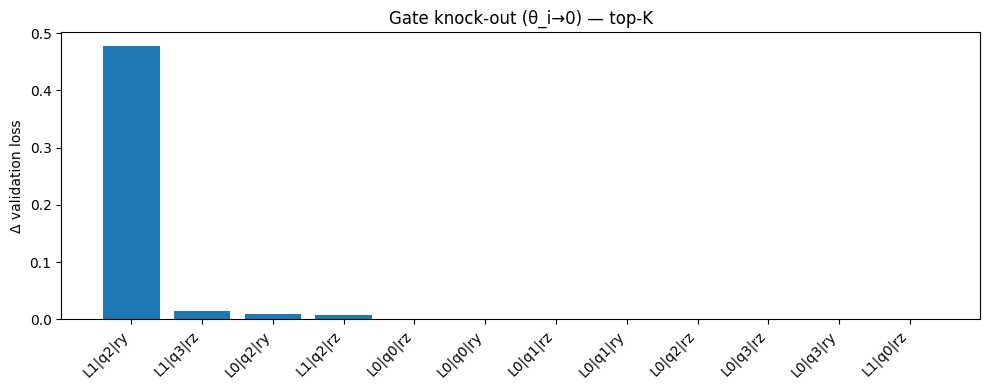

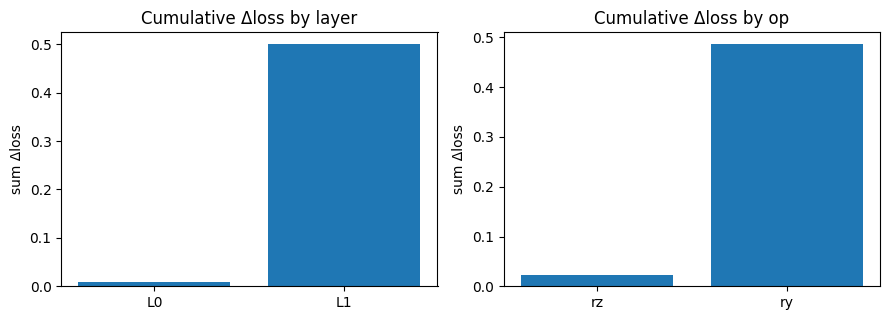

In [21]:
# Metadata for parameters: (layer, qubit, op) built earlier as THETA_META
def val_loss(theta_vals):
    z = predict_score(theta_vals, X_val, estimator=est_train).ravel()
    p = score_to_proba(z)
    return bce_loss(p, y_val)

base_L = val_loss(theta_star)
delta_losses = []
for i in range(len(theta_star)):
    th = theta_star.copy()
    th[i] = 0.0  # knock-out
    dL = val_loss(th) - base_L
    delta_losses.append(max(0.0, dL))
delta_losses = np.array(delta_losses)

# Top-K labeled bar (sorted)
K = min(12, len(delta_losses))
order = np.argsort(-delta_losses)[:K]
labels = [f"L{L}|q{q}|{op}" for (L,q,op) in np.array(THETA_META, dtype=object)[order]]

plt.figure(figsize=(10,4))
plt.bar(range(K), delta_losses[order])
plt.xticks(range(K), labels, rotation=45, ha="right")
plt.ylabel("Δ validation loss"); plt.title("Gate knock-out (θ_i→0) — top-K")
plt.tight_layout(); plt.show()

# Summaries by layer and by op type
nL = CFG.n_layers
by_layer = np.zeros(nL); by_op = {"rz":0.0, "ry":0.0}
for i, (L,q,op) in enumerate(THETA_META):
    by_layer[L] += delta_losses[i]
    by_op[op] += delta_losses[i]

plt.figure(figsize=(9,3.3))
plt.subplot(1,2,1)
plt.bar(range(nL), by_layer)
plt.xticks(range(nL), [f"L{L}" for L in range(nL)])
plt.title("Cumulative Δloss by layer"); plt.ylabel("sum Δloss")

plt.subplot(1,2,2)
plt.bar(range(len(by_op)), list(by_op.values()))
plt.xticks(range(len(by_op)), list(by_op.keys()))
plt.title("Cumulative Δloss by op"); plt.ylabel("sum Δloss")
plt.tight_layout(); plt.show()

### 📋 Feature Importance Ranking Summary

Combine all attribution methods into a unified ranking table.
The **Mean Rank** provides a consensus importance ordering across all methods.

In [22]:
import pandas as pd
def ranks_desc(v):  # 1 = most important
    return (len(v) - np.argsort(np.argsort(v)))  # 1..n ranks

df = pd.DataFrame({
    "IG_norm":  normalize(IG_mean, "sum1"),
    "GI_norm":  normalize(GI_mean, "sum1"),
    "NS_norm":  normalize(NS_mean, "sum1"),
    "OCC_norm": normalize(OCC,     "sum1"),
}, index=feat_labels)

rank_df = df.apply(ranks_desc, axis=0)
rank_df["MeanRank"] = rank_df.mean(axis=1)
display(rank_df.sort_values("MeanRank"))
print("\nNormalized scores:")
display(df.loc[rank_df.sort_values('MeanRank').index])

,IG_norm,GI_norm,NS_norm,OCC_norm,MeanRank
petal width,1,1,1,1,1.00
petal length,2,2,3,2,2.25
sepal width,3,3,2,3,2.75
sepal length,4,4,4,4,4.00



Normalized scores:


,IG_norm,GI_norm,NS_norm,OCC_norm
petal width,0.815528,0.836641,0.613390,0.855931
petal length,0.106111,0.105284,0.101240,0.132081
sepal width,0.075436,0.048019,0.217786,0.011988
sepal length,0.002925,0.010057,0.067584,0.000000


### 📈 Partial Dependence Plots

Visualize how the model's prediction changes as individual features vary, while holding other features at their mean values.

This reveals the **functional relationship** between each feature and the predicted probability.

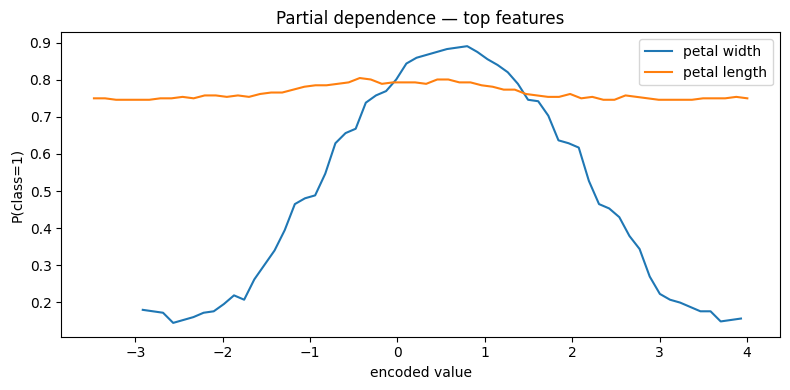

In [23]:
def partial_dependence(theta_vals, Xref, j, points=60, margin=0.15, estimator=None):
    e = estimator or est_plot
    fmin, fmax = Xref[:, j].min(), Xref[:, j].max()
    span = fmax - fmin
    xs = np.linspace(fmin - margin*span, fmax + margin*span, points)
    probs = []
    template = Xref.mean(axis=0)  # other features fixed to mean encoded value
    for xj in xs:
        x = template.copy()
        x[j] = xj
        z = vqc_expectation(theta_vals, x, estimator=e)
        probs.append(score_to_proba(z))
    return xs, np.array(probs)

# Plot for the top-2 features by IG
order = np.argsort(-IG_mean)
top2 = order[:2]
plt.figure(figsize=(8,4))
for j in top2:
    xs, ps = partial_dependence(theta_star, Xenc, j, estimator=est_plot)
    plt.plot(xs, ps, label=feat_labels[j])
plt.xlabel("encoded value"); plt.ylabel("P(class=1)")
plt.title("Partial dependence — top features")
plt.legend(); plt.tight_layout(); plt.show()

## 📐 Faithfulness & Quality Metrics

### 🎯 Evaluating Saliency Map Quality

Beyond feature rankings, we evaluate the **quality** of our saliency maps using established XAI metrics:

1. **Deletion Metric (Fidelity):** If we mask the most salient features, does the prediction change significantly?
   - Higher Δ probability → more faithful explanations

2. **Average Sensitivity:** How stable is the saliency under small input perturbations?
   - Lower sensitivity → more robust attributions

3. **Saliency Entropy:** Information-theoretic measure of attribution spread
   $$H(s) = -\sum_j \hat{s}_j \log(\hat{s}_j)$$
   - Lower entropy → more focused explanations

4. **Saliency Sparseness:** L1/L2 ratio measuring concentration
   $$\text{Sparseness} = \frac{\|s\|_1}{\|s\|_2}$$
   - Lower ratio → sparser, more interpretable maps

In [24]:
# ============================================================
# FAITHFULNESS METRICS: Deletion, Average Sensitivity, Entropy, Sparseness
# ============================================================

def deletion_score(theta_vals, x_vec, saliency, baseline_vec=None, top_k=2):
    """
    Deletion Metric: Mask top-k salient features and measure prediction change.
    
    Higher Δ probability indicates the saliency correctly identifies important features.
    
    Args:
        theta_vals: Trained model parameters
        x_vec: Input sample
        saliency: Saliency scores for the sample
        baseline_vec: Replacement values for masked features
        top_k: Number of top features to mask
    
    Returns:
        Absolute change in probability after masking top-k features
    """
    if baseline_vec is None:
        baseline_vec = BASELINE_VEC
    
    # Original prediction
    z_orig = vqc_expectation(theta_vals, x_vec, estimator=est_train)
    p_orig = score_to_proba(z_orig)
    
    # Identify top-k salient features
    top_idx = np.argsort(-np.abs(saliency))[:top_k]
    
    # Mask top features with baseline values
    x_masked = x_vec.copy()
    for idx in top_idx:
        x_masked[idx] = baseline_vec[idx]
    
    # Prediction after masking
    z_masked = vqc_expectation(theta_vals, x_masked, estimator=est_train)
    p_masked = score_to_proba(z_masked)
    
    return abs(p_orig - p_masked)


def average_sensitivity(theta_vals, x_vec, sigma=0.05, n_samples=20):
    """
    Average Sensitivity: Measures how stable saliency is under input noise.
    
    Lower values indicate more robust, reliable attributions.
    
    Args:
        theta_vals: Trained model parameters
        x_vec: Input sample
        sigma: Noise standard deviation
        n_samples: Number of noisy samples to average
    
    Returns:
        Average L2 distance between original and noisy saliency maps
    """
    # Original saliency
    s_orig = np.abs(grad_input_param_shift(theta_vals, x_vec))
    
    diffs = []
    for _ in range(n_samples):
        # Add small noise to input
        x_noisy = x_vec + np.random.normal(0, sigma, size=x_vec.shape)
        s_noisy = np.abs(grad_input_param_shift(theta_vals, x_noisy))
        
        # L2 distance between saliency maps
        diff = np.linalg.norm(s_orig - s_noisy)
        diffs.append(diff)
    
    return np.mean(diffs)


def saliency_entropy(saliency):
    """
    Saliency Entropy: Information-theoretic measure of attribution spread.
    
    Lower entropy indicates more focused, interpretable explanations.
    
    Args:
        saliency: Raw saliency scores
    
    Returns:
        Shannon entropy of normalized saliency distribution
    """
    # Normalize to probability distribution
    s_abs = np.abs(saliency)
    s_sum = s_abs.sum()
    if s_sum < 1e-10:
        return 0.0
    s_norm = s_abs / s_sum
    
    # Compute entropy (avoiding log(0))
    s_norm = np.clip(s_norm, 1e-10, 1.0)
    entropy = -np.sum(s_norm * np.log(s_norm))
    
    return entropy


def saliency_sparseness(saliency):
    """
    Saliency Sparseness: L1/L2 ratio measuring concentration.
    
    Lower values indicate sparser, more focused attributions.
    Values range from 1 (maximally sparse) to sqrt(n) (uniform).
    
    Args:
        saliency: Raw saliency scores
    
    Returns:
        L1/L2 ratio (lower = sparser)
    """
    s_abs = np.abs(saliency)
    l1 = np.sum(s_abs)
    l2 = np.linalg.norm(s_abs)
    
    if l2 < 1e-10:
        return 0.0
    
    return l1 / l2

### 📊 Compute Faithfulness Metrics

Evaluate all quality metrics across the validation set.

In [25]:
# ============================================================
# Compute metrics over validation samples
# ============================================================

print("Computing faithfulness metrics over validation set...")
print("=" * 50)

deletion_scores = []
sensitivity_scores = []
entropy_scores = []
sparseness_scores = []

for i in range(len(X_val)):
    x_i = X_val[i]
    
    # Get saliency for this sample
    saliency_i = np.abs(grad_input_param_shift(theta_star, x_i))
    
    # Deletion score (top-2 features)
    del_score = deletion_score(theta_star, x_i, saliency_i, top_k=2)
    deletion_scores.append(del_score)
    
    # Average sensitivity
    sens_score = average_sensitivity(theta_star, x_i, sigma=0.05, n_samples=10)
    sensitivity_scores.append(sens_score)
    
    # Entropy
    ent_score = saliency_entropy(saliency_i)
    entropy_scores.append(ent_score)
    
    # Sparseness
    sparse_score = saliency_sparseness(saliency_i)
    sparseness_scores.append(sparse_score)

# Summary statistics
print(f"\n Faithfulness Metrics Summary (n={len(X_val)} samples)")
print("-" * 50)
print(f"Deletion (Δprob when masking top-2):")
print(f"  Mean: {np.mean(deletion_scores):.4f} ± {np.std(deletion_scores):.4f}")
print(f"  Higher → saliency identifies truly important features")

print(f"\nAverage Sensitivity:")
print(f"  Mean: {np.mean(sensitivity_scores):.4f} ± {np.std(sensitivity_scores):.4f}")
print(f"  Lower → more stable/robust saliency")

print(f"\nSaliency Entropy:")
print(f"  Mean: {np.mean(entropy_scores):.4f} ± {np.std(entropy_scores):.4f}")
print(f"  Lower → more focused explanations")

print(f"\nSaliency Sparseness (L1/L2):")
print(f"  Mean: {np.mean(sparseness_scores):.4f} ± {np.std(sparseness_scores):.4f}")
print(f"  Range: [1, √{len(feat_labels)}={np.sqrt(len(feat_labels)):.2f}]")
print(f"  Lower → sparser attributions")

Computing faithfulness metrics over validation set...

 Faithfulness Metrics Summary (n=15 samples)
--------------------------------------------------
Deletion (Δprob when masking top-2):
  Mean: 0.3222 ± 0.2239
  Higher → saliency identifies truly important features

Average Sensitivity:
  Mean: 0.0290 ± 0.0097
  Lower → more stable/robust saliency

Saliency Entropy:
  Mean: 0.6976 ± 0.1498
  Lower → more focused explanations

Saliency Sparseness (L1/L2):
  Mean: 1.2633 ± 0.0795
  Range: [1, √4=2.00]
  Lower → sparser attributions


### 📈 Faithfulness Metrics Visualization

Distribution of quality metrics across validation samples.

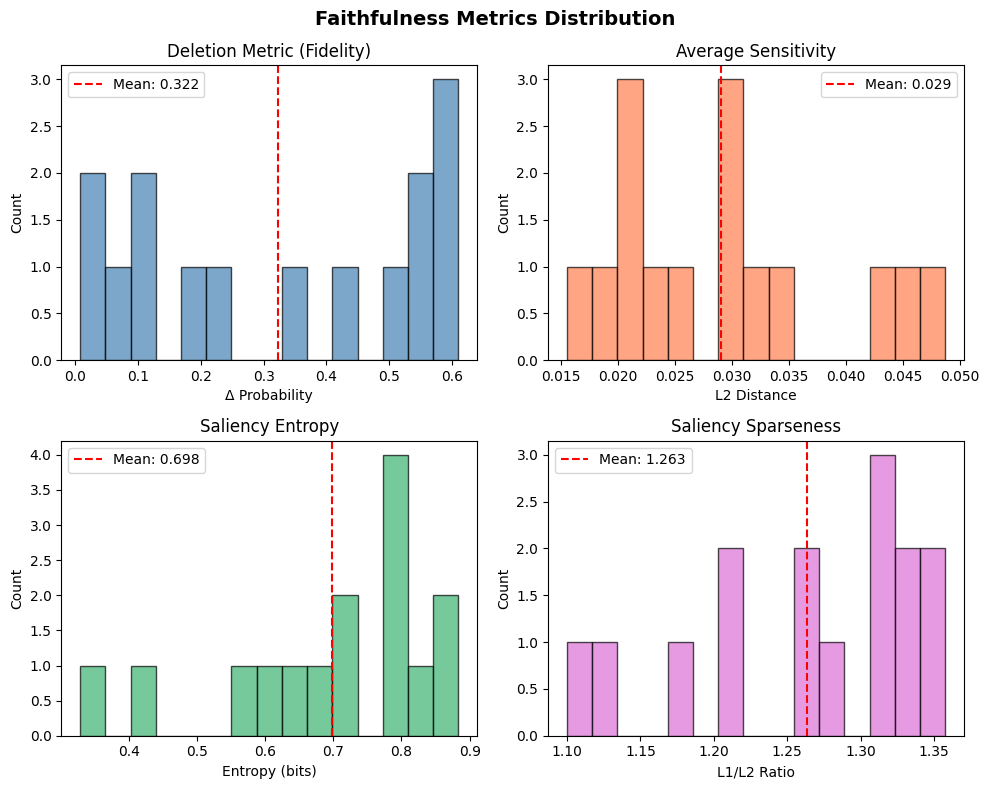

In [26]:
# Visualize faithfulness metrics distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Deletion scores
axes[0, 0].hist(deletion_scores, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(np.mean(deletion_scores), color='red', linestyle='--', label=f'Mean: {np.mean(deletion_scores):.3f}')
axes[0, 0].set_xlabel('Δ Probability')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Deletion Metric (Fidelity)')
axes[0, 0].legend()

# Sensitivity scores
axes[0, 1].hist(sensitivity_scores, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(np.mean(sensitivity_scores), color='red', linestyle='--', label=f'Mean: {np.mean(sensitivity_scores):.3f}')
axes[0, 1].set_xlabel('L2 Distance')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Average Sensitivity')
axes[0, 1].legend()

# Entropy scores
axes[1, 0].hist(entropy_scores, bins=15, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 0].axvline(np.mean(entropy_scores), color='red', linestyle='--', label=f'Mean: {np.mean(entropy_scores):.3f}')
axes[1, 0].set_xlabel('Entropy (bits)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Saliency Entropy')
axes[1, 0].legend()

# Sparseness scores
axes[1, 1].hist(sparseness_scores, bins=15, edgecolor='black', alpha=0.7, color='orchid')
axes[1, 1].axvline(np.mean(sparseness_scores), color='red', linestyle='--', label=f'Mean: {np.mean(sparseness_scores):.3f}')
axes[1, 1].set_xlabel('L1/L2 Ratio')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Saliency Sparseness')
axes[1, 1].legend()

plt.suptitle('Faithfulness Metrics Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


*Part of the QAMP Project: "QNNs — Saliency & Sensitivity Kit"*